In [1]:

import matplotlib.pyplot as plt

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_model(input_shape, num_classes):
    """
    Builds a lightweight CNN model for audio classification.

    Args:
        input_shape (tuple): The shape of the input spectrograms (height, width, channels).
        num_classes (int): The number of output classes (e.g., 2 for melody vs. other).

    Returns:
        A TensorFlow Keras model.
    """
    model = models.Sequential([
        # Input Layer
        layers.Input(shape=input_shape),

        # First Convolutional Block
        # Using smaller filters (3x3) and fewer of them (8) to keep the model small.
        layers.Conv2D(4, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Second Convolutional Block
        layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Third Convolutional Block
        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Flatten the feature map to feed into the dense layers
        layers.Flatten(),

        # Dense Layer for classification
        # A smaller dense layer (32 units) to reduce parameters
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.5), # Dropout helps prevent overfitting

        # Output Layer
        # The number of units equals the number of classes.
        # Use 'softmax' for multi-class or 'sigmoid' for binary classification.
        layers.Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')
    ])

    return model

# Example of how to create the model
# These values will be determined during data preprocessing
INPUT_SHAPE = (128, 128, 1) # (n_mels, time_steps, channels)
NUM_CLASSES = 2 # (lg_melody, other_sounds)

model = build_cnn_model(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 4)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │        65,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,090 (262.07 KB)

 Trainable params: 67,090 (262.07 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='data/other_sounds',
                        extract=True)

645701632/Unknown 40s 0us/step

'./data/other_sounds/esc-50_extracted'

In [8]:
import librosa
import numpy as np
import os
from sklearn.model_selection import train_test_split

# --- Configuration ---
DATA_PATH = "data/"


# --- Configuration ---
CONFIG = {
    "sample_rate": 16000,    # Hz
    "window_duration": 1.5,  # seconds (length of one spectrogram)
    "hop_duration": 0.1,     # seconds (how much to slide the window)
    "n_mels": 64,            # Number of Mel bands (reduced for ESP32 efficiency)
    "n_fft": 1024,           # Number of FFT points
    "max_spectrogram_width": 48 # Fixed width for spectrograms (time steps)
}


def process_audio_file(audio_path, class_label, config):
    """
    Loads an audio file and converts it into one or more Mel spectrograms.

    - If class_label is 'lg_melody', it uses a sliding window to generate
      multiple, overlapping spectrograms from the entire clip.
    - Otherwise, it generates a single spectrogram from the start of the clip.

    Args:
        audio_path (str): Path to the audio file.
        class_label (str): The name of the class (e.g., 'lg_melody').
        config (dict): A dictionary of processing parameters.

    Returns:
        A list of spectrograms. Returns an empty list if processing fails.
    """
    try:
        y, sr = librosa.load(audio_path, sr=config["sample_rate"])
    except Exception as e:
        print(f"Error loading {audio_path}: {e}")
        return []

    spectrograms = []
    window_samples = int(config["window_duration"] * config["sample_rate"])
    hop_samples = int(config["hop_duration"] * config["sample_rate"])

    if class_label == 'lg_melody':
        # --- Sliding Window for the Target Melody ---
        for start in range(0, len(y) - window_samples, hop_samples):
            end = start + window_samples
            chunk = y[start:end]
            
            # Generate Mel spectrogram for the chunk
            spectrogram = librosa.feature.melspectrogram(
                y=chunk, 
                sr=sr, 
                n_mels=config["n_mels"], 
                n_fft=config["n_fft"]
            )
            log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
            
            # Standardize spectrogram width
            if log_spectrogram.shape[1] > config["max_spectrogram_width"]:
                log_spectrogram = log_spectrogram[:, :config["max_spectrogram_width"]]
            else:
                pad_width = config["max_spectrogram_width"] - log_spectrogram.shape[1]
                log_spectrogram = np.pad(log_spectrogram, ((0, 0), (0, pad_width)), mode='constant')
            
            spectrograms.append(log_spectrogram)
    
    else:
        # --- Single Slice for Other Sounds ---
        # Truncate or pad the audio to the window duration
        if len(y) > window_samples:
            y = y[:window_samples]
        else:
            y = np.pad(y, (0, window_samples - len(y)), 'constant')

        # Generate a single Mel spectrogram
        spectrogram = librosa.feature.melspectrogram(
            y=y, 
            sr=config["sample_rate"], 
            n_mels=config["n_mels"], 
            n_fft=config["n_fft"]
        )
        log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        
        # Standardize spectrogram width (same logic as above)
        if log_spectrogram.shape[1] > config["max_spectrogram_width"]:
            log_spectrogram = log_spectrogram[:, :config["max_spectrogram_width"]]
        else:
            pad_width = config["max_spectrogram_width"] - log_spectrogram.shape[1]
            log_spectrogram = np.pad(log_spectrogram, ((0, 0), (0, pad_width)), mode='constant')
            
        spectrograms.append(log_spectrogram)
        
    return spectrograms

def load_data(data_path):
    """Loads all audio files, converts them, and creates labels."""
    X, y = [], []
    class_map = {label: i for i, label in enumerate(os.listdir(data_path))}
    
    for label, class_idx in class_map.items():
        class_dir = os.path.join(data_path, label)
        for filename in os.listdir(class_dir):
            if filename.endswith(".wav"):
                filepath = os.path.join(class_dir, filename)
                spectrogram_list = process_audio_file(filepath, label, CONFIG)
                
                if spectrogram_list:
                    # Add all spectrograms from the list to our dataset
                    X.extend(spectrogram_list)
                    # Add a label for each spectrogram that was generated
                    y.extend([class_idx] * len(spectrogram_list))
                    
    return np.array(X), np.array(y), class_map

# --- Execute Data Preparation ---
X, y, class_map = load_data(DATA_PATH)
print("Class mapping:", class_map)

# Add a channel dimension for the CNN
X = X[..., np.newaxis]

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1, random_state=42, stratify=None)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Class mapping: {'other_sounds': 0, 'lg_melody': 1}
Training set shape: (2037, 64, 48, 1)
Validation set shape: (113, 64, 48, 1)
Test set shape: (114, 64, 48, 1)


In [13]:
# --- Compile the Model ---
model = build_cnn_model(input_shape=X_train.shape[1:], num_classes=len(class_map))

# Using Adam optimizer and SparseCategoricalCrossentropy because our labels are integers.
# If you one-hot encode your labels, use CategoricalCrossentropy.
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# --- Train the Model ---
EPOCHS = 30
BATCH_SIZE = 32

history = model.fit(X, y,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X, y),
                    callbacks=[
                        # Stop training early if validation loss stops improving
                        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                    ])

# --- Evaluate on Test Set ---
test_loss, test_acc = model.evaluate(X, y, verbose=2)
print(f'\nTest accuracy: {test_acc:.2f}')

Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9178 - loss: 0.3049 - val_accuracy: 0.9960 - val_loss: 0.0322
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9611 - loss: 0.0829 - val_accuracy: 0.9978 - val_loss: 0.0171
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9669 - loss: 0.0614 - val_accuracy: 0.9982 - val_loss: 0.0094
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9664 - loss: 0.0543 - val_accuracy: 0.9960 - val_loss: 0.0122
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9682 - loss: 0.0543 - val_accuracy: 0.9991 - val_loss: 0.0071
Epoch 6/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9669 - loss: 0.0546 - val_accuracy: 0.9973 - val_loss: 0.0096
Epoch 7/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9629 - loss: 0.0548 - val_accuracy: 0.9965 - val_loss: 0.0109
Epoch 8/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9695 - loss: 0.0515 - val_accuracy: 0.9991 - v

In [14]:
# Create a representative dataset for quantization
def representative_dataset():
    for i in range(100): # Use a subset of the training data
      # Ensure the data type is float32
      yield [X_train[i:i+1].astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.representative_dataset = representative_dataset
# Ensure that if the ops are not supported by the TFLite runtime, the converter throws an error.
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (or int8)
#converter.inference_input_type = tf.uint8 # or tf.int8
#converter.inference_output_type = tf.uint8 # or tf.int8

tflite_quant_model = converter.convert()

# --- Save the Model ---
with open('lg_sound_model.tflite', 'wb') as f:
    f.write(tflite_quant_model)

print("TFLite model saved as lg_sound_model.tflite")

INFO:tensorflow:Assets written to: /tmp/tmp93q_93ft/assets


INFO:tensorflow:Assets written to: /tmp/tmp93q_93ft/assets


Saved artifact at '/tmp/tmp93q_93ft'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 48, 1), dtype=tf.float32, name='keras_tensor_55')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  130522801495824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130522801495056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130522801501200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130522801495248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130522801501584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130522801501392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130522801501968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130522801501776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130522801502352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130522801502160: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite model sa

W0000 00:00:1754329050.159674  304256 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1754329050.159689  304256 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-08-04 13:37:30.159882: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp93q_93ft
2025-08-04 13:37:30.160679: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-08-04 13:37:30.160691: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp93q_93ft
2025-08-04 13:37:30.167648: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-08-04 13:37:30.207367: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp93q_93ft
2025-08-04 13:37:30.219829: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 59949 microseconds.


In [14]:
y[-10:]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Golden spectrogram shape: (64, 48)


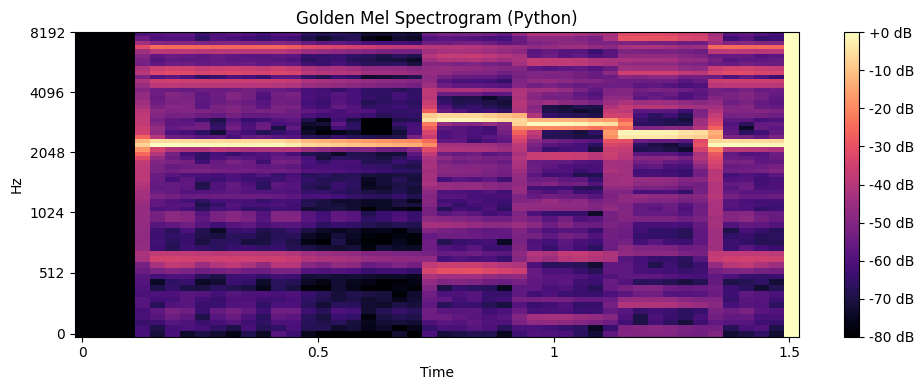

In [3]:
# --- Generate Golden Spectrogram ---
golden_spectrograms = process_audio_file('data/lg_melody/lg_washer.wav', 'lg_melody', CONFIG)
golden_spectrogram = golden_spectrograms[0] # Use the first spectrogram
print("Golden spectrogram shape:", golden_spectrogram.shape)


plt.figure(figsize=(10, 4))
librosa.display.specshow(golden_spectrogram, sr=CONFIG['sample_rate'], x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Golden Mel Spectrogram (Python)')
plt.tight_layout()
plt.show()

In [ ]:
# --- Paste C++ Spectrogram Data Here ---
cpp_spectrogram_str = """\n-1.6974,-49.5520,-54.6180,-56.7331,-51.0587,-49.6455,-58.2551,-66.1369,-64.7337,-63.5234,-63.3997,-71.7656,-69.8138,-64.7892,-62.3055,-70.1227,-69.3341,-68.1538,-69.3383,-69.0832,-67.6715,-66.3435,-63.9267,-61.4027,-65.0152,-66.6854,-70.4202,-59.9524,-58.8734,-67.0953,-72.9172,-73.2598,-71.1176,-70.8372,-71.6873,-68.7092,-72.5867,-69.4563,-72.0664,-65.6291,-63.5798,-65.7105,-72.8272,-73.3460,-75.5729,-72.2621,-70.1611,-72.6812,-72.3395,-72.9173,-72.1899,-70.2132,-70.8025,-69.9956,-73.2944,-69.1189,-66.5106,-67.9060,-69.5346,-68.4819,-63.7575,-66.1443,-67.3846,-35.2820,\n-3.6733,-51.4769,-50.6856,-55.7306,-51.6961,-51.4477,-56.2417,-65.1323,-68.5316,-69.9575,-71.6266,-64.1930,-66.0496,-63.5410,-61.6365,-67.2212,-67.6848,-64.1315,-67.6429,-64.8357,-61.0672,-71.1263,-61.7018,-65.0170,-62.7650,-64.9718,-61.6051,-60.9937,-62.5520,-65.4987,-68.3070,-68.6228,-69.3343,-72.5924,-72.3427,-73.4515,-75.0707,-74.6611,-70.7660,-66.5157,-66.7451,-69.8777,-73.2749,-72.9394,-72.6865,-73.5584,-71.9086,-73.1830,-74.1753,-74.4362,-72.3983,-70.7812,-71.7575,-70.3991,-73.4267,-71.0711,-67.9045,-69.2858,-68.3056,-67.1008,-62.7942,-66.1477,-67.3753,-32.5278,\n-6.9108,-46.9319,-46.9966,-58.0385,-60.3545,-60.7176,-64.7371,-67.0296,-69.7148,-67.4713,-61.7687,-57.1535,-59.9293,-66.1621,-66.2013,-64.1655,-67.1665,-65.3854,-66.9201,-66.3916,-59.1785,-67.0895,-68.2867,-58.6521,-59.0295,-55.8545,-49.8496,-51.1735,-56.8883,-56.7102,-58.1193,-58.8519,-64.8217,-69.6888,-72.2522,-72.6182,-70.8934,-67.3921,-68.0624,-69.2674,-68.4614,-69.3894,-71.0449,-68.8639,-70.1897,-70.0995,-71.5706,-73.0032,-71.1583,-70.0447,-71.0906,-75.1643,-76.6049,-76.4406,-70.6312,-69.3434,-67.0104,-69.5638,-69.9035,-61.9375,-54.2077,-58.8166,-66.3924,-31.6817,\n-12.2672,-51.3584,-49.8573,-49.6638,-53.2793,-59.2021,-59.3860,-64.9108,-69.7339,-66.3721,-59.2979,-60.1618,-66.0356,-69.9256,-71.5739,-63.6930,-67.2978,-65.7124,-65.6037,-67.2760,-64.6396,-65.9143,-63.9426,-57.1940,-54.5746,-58.4701,-49.0114,-51.2742,-59.2792,-58.5141,-60.1125,-61.2272,-64.5414,-63.9181,-63.7891,-66.7213,-67.6540,-65.5713,-64.3923,-67.4263,-68.7680,-66.4069,-66.7080,-68.0521,-69.1920,-70.9566,-71.7032,-72.6766,-72.4171,-70.5050,-70.1123,-72.7505,-72.7960,-73.1460,-69.2646,-67.4266,-65.0193,-66.3290,-63.8983,-60.0998,-54.9485,-60.1350,-65.5030,-31.9118,\n-24.8459,-42.3398,-38.9216,-41.6212,-47.9531,-58.1908,-61.5748,-54.6256,-60.7117,-68.3529,-65.7610,-64.9018,-68.9984,-62.8631,-61.0542,-69.1402,-69.1792,-64.4768,-63.5662,-69.0532,-62.8681,-61.5321,-64.5417,-62.0210,-61.6502,-65.5501,-61.1358,-63.6647,-68.4246,-62.9097,-61.3479,-62.0221,-61.1709,-60.3824,-61.2100,-64.8226,-68.6398,-66.2379,-67.3611,-67.2033,-65.7849,-64.6731,-66.0809,-66.8540,-68.8120,-72.4680,-69.9225,-69.7391,-73.2472,-71.9048,-73.4800,-73.6313,-72.5486,-69.4160,-67.2733,-65.5393,-64.8531,-63.3719,-60.6350,-62.7869,-63.6071,-64.4004,-65.3610,-33.0864,\n-18.8032,-42.5215,-42.9272,-46.9604,-48.0106,-54.6552,-56.1280,-55.5233,-62.4616,-69.3524,-63.4524,-63.0193,-61.4916,-59.8643,-73.4468,-73.4344,-67.2133,-62.7642,-65.8319,-66.9410,-65.9195,-63.8567,-63.0127,-64.3052,-64.4192,-62.0971,-65.3046,-67.3799,-67.5926,-67.7372,-68.5378,-64.6958,-61.7014,-61.9688,-66.9572,-67.0339,-66.1144,-65.1378,-66.3380,-64.3549,-65.1063,-63.5188,-62.1795,-61.1641,-61.9835,-68.5509,-65.7242,-69.2955,-68.5693,-69.0575,-70.3586,-72.0413,-68.8534,-65.8146,-61.9054,-62.0770,-64.6731,-64.8202,-64.0818,-64.8362,-65.5556,-65.0839,-64.2325,-33.4073,\n-11.2604,-44.9593,-53.9631,-53.9681,-55.1333,-49.3368,-48.3493,-54.4615,-59.4988,-59.7565,-50.9682,-53.0487,-59.6520,-63.1582,-60.4722,-63.9909,-61.6006,-58.7589,-61.0263,-62.1572,-64.5627,-62.0472,-62.6229,-60.7995,-63.5330,-63.9225,-63.7751,-68.5041,-69.7092,-71.3107,-68.1593,-68.3560,-65.1164,-62.5159,-68.1707,-68.5581,-68.8183,-68.9202,-64.1034,-68.4630,-66.9257,-66.0180,-64.9933,-64.2706,-64.9377,-69.3404,-67.4769,-69.8484,-72.3711,-70.9233,-72.9866,-71.1193,-69.7748,-67.9137,-64.8966,-65.9013,-66.6917,-66.8884,-66.1386,-66.2892,-65.7446,-61.4616,-60.4011,-34.9662,\n-8.0541,-44.5717,-47.1881,-51.8353,-49.1248,-40.4048,-41.4965,-57.4622,-60.0762,-56.2519,-52.3614,-52.1280,-53.1139,-64.2396,-66.4095,-65.3704,-61.1139,-56.3549,-64.9161,-63.5385,-63.0123,-60.6254,-68.0717,-67.8541,-70.5049,-66.0346,-64.8363,-68.6910,-71.5804,-70.9960,-73.1262,-73.6081,-72.9224,-68.9108,-72.2079,-72.3323,-73.1260,-72.9072,-71.8874,-75.3980,-72.1263,-72.5394,-72.3229,-69.9752,-72.8346,-73.7131,-71.8822,-73.2774,-75.3088,-77.0606,-77.0056,-75.0225,-74.1999,-73.8291,-75.5146,-71.9759,-72.0531,-72.3198,-71.1497,-69.7000,-67.5668,-60.1384,-56.4543,-36.8668,\n-5.9743,-53.5449,-55.3556,-55.7454,-59.8273,-49.3622,-51.1889,-56.6715,-62.2732,-51.6162,-50.2478,-54.2276,-61.0589,-68.9522,-59.7676,-62.6103,-68.2044,-65.3047,-72.1599,-66.3160,-59.7442,-63.8214,-63.4936,-58.2665,-61.8097,-65.5546,-67.6225,-66.1559,-63.7200,-67.1877,-66.7694,-68.2628,-71.0426,-68.3461,-70.0042,-71.1232,-70.1174,-69.0298,-69.1845,-70.3220,-70.5834,-70.4088,-68.8991,-71.3207,-70.5304,-70.2607,-71.6411,-72.0294,-71.9358,-73.8342,-74.5887,-72.5366,-72.1969,-73.9066,-69.8232,-68.2273,-69.4091,-70.8247,-69.5887,-67.4202,-64.7233,-60.0987,-58.0937,-37.7017,\n-4.4703,-49.3233,-55.1582,-59.9074,-56.3615,-54.2555,-56.2173,-63.2033,-58.2279,-53.6267,-52.3261,-52.2263,-60.8171,-63.0924,-59.8950,-65.4187,-64.7819,-66.1640,-67.0620,-59.8719,-61.4238,-58.4918,-61.6855,-54.9642,-61.7614,-61.3961,-63.2528,-63.0999,-59.7411,-62.7050,-64.8521,-67.3834,-66.6588,-68.9572,-69.1324,-68.6256,-63.9634,-64.1188,-65.8348,-66.2983,-67.0668,-68.2316,-66.4479,-66.9930,-65.9050,-70.3668,-71.0055,-69.4643,-70.2258,-74.1366,-69.0919,-68.7046,-68.3892,-69.6400,-70.2728,-66.7448,-68.5149,-67.8485,-68.3843,-67.5251,-63.5859,-57.9421,-57.6972,-39.2806,\n-3.4062,-47.1426,-57.8478,-60.0724,-57.1048,-51.7773,-51.1160,-55.3816,-55.4292,-54.2363,-58.4139,-58.4187,-60.7181,-60.6613,-59.5096,-58.0422,-59.3164,-61.0821,-63.6211,-66.7607,-69.0865,-63.1503,-58.3055,-57.1895,-61.3116,-63.9511,-63.1805,-60.6489,-65.0334,-67.1653,-64.9267,-65.4233,-66.3604,-65.9338,-67.1097,-66.3512,-64.1223,-69.9917,-66.9718,-68.0145,-66.8137,-65.4111,-66.3470,-65.5107,-67.1324,-70.1673,-69.0393,-69.0848,-72.7507,-70.6712,-70.5966,-68.9327,-68.9425,-68.7880,-66.3226,-67.8372,-68.1972,-65.8762,-66.7487,-65.1838,-62.0908,-59.3618,-57.7124,-41.0114,\n-2.6029,-44.5882,-47.5160,-54.9855,-53.2295,-51.0513,-53.0381,-58.1497,-55.4635,-58.3183,-62.3137,-58.7627,-62.0226,-60.5957,-60.0421,-62.4233,-57.5875,-55.4268,-61.6649,-63.9154,-61.1334,-54.8136,-57.4686,-63.4984,-62.5211,-55.9231,-58.8263,-55.2038,-62.4331,-66.0095,-63.2266,-62.4384,-64.8216,-64.0026,-63.8545,-64.3059,-65.2823,-64.1236,-64.3562,-65.1310,-65.2223,-65.6754,-60.3040,-59.6328,-61.1344,-70.3918,-67.9584,-65.4239,-72.3700,-68.6257,-69.6005,-70.3649,-66.2113,-66.0190,-63.2703,-62.5104,-65.2672,-65.1881,-62.9442,-63.0885,-59.4819,-57.7367,-58.3956,-42.3742,\n-2.1324,-47.7909,-53.7297,-60.8850,-47.3226,-43.7676,-46.2216,-58.5182,-54.9965,-54.9585,-65.4393,-58.1904,-60.6891,-60.8677,-59.8522,-55.5663,-62.0999,-60.1474,-61.2426,-63.9526,-61.0790,-57.0321,-56.6470,-57.7494,-56.1864,-57.6952,-57.1302,-57.6556,-61.2424,-61.1067,-59.1688,-60.8215,-58.3340,-54.4543,-55.3141,-60.2388,-62.1144,-62.5592,-62.6854,-70.1095,-68.3061,-64.7801,-64.5659,-61.9065,-63.5208,-66.7084,-67.2866,-63.3280,-67.6999,-61.7491,-61.8273,-67.8547,-67.3179,-64.7379,-64.5660,-63.2471,-65.5426,-65.1709,-57.1543,-56.9685,-57.6417,-57.2166,-60.6603,-45.2353,\n-1.6339,-41.7697,-51.1049,-69.4860,-48.3366,-45.9937,-54.8085,-60.2346,-63.3489,-60.8201,-59.6230,-62.1923,-63.9559,-66.4045,-63.3924,-56.5448,-61.3566,-65.1391,-60.5208,-62.1716,-63.1370,-61.3658,-62.0237,-58.6693,-55.7267,-58.6600,-55.3459,-57.9801,-62.0910,-61.5620,-60.9956,-64.4443,-60.3164,-54.5605,-55.2476,-62.4766,-61.9073,-64.1249,-69.2403,-70.5047,-70.9924,-67.2703,-67.5467,-64.3969,-66.6056,-65.2487,-66.3456,-65.2694,-66.4403,-60.5897,-60.9161,-66.4537,-65.7483,-62.3989,-67.0229,-69.3023,-67.5355,-64.5291,-58.3514,-57.4350,-58.8237,-58.3789,-60.8948,-44.2197,\n-1.1686,-48.0169,-63.6021,-54.6043,-53.3153,-55.0772,-53.3731,-56.1849,-54.5341,-58.6495,-59.6354,-57.8482,-54.8918,-55.7671,-64.6955,-62.9809,-60.1908,-62.3856,-60.6841,-60.4662,-62.3278,-56.7742,-57.5435,-58.4106,-56.9487,-54.5540,-53.5235,-55.4966,-59.4024,-61.7576,-63.9655,-66.6966,-64.9243,-64.8534,-63.3917,-63.2922,-67.0367,-68.2066,-67.5671,-72.2736,-68.5387,-68.7880,-68.6396,-69.8274,-70.5402,-66.3476,-68.5308,-69.9315,-69.7226,-69.2337,-69.9736,-72.0501,-70.2961,-68.8076,-70.5768,-69.5094,-69.5681,-67.6277,-64.6213,-63.2785,-56.8820,-56.5457,-57.8824,-48.2146,\n-1.1334,-45.0055,-52.4689,-51.1201,-45.3507,-44.4516,-52.4654,-53.8270,-45.9775,-50.7039,-52.5291,-48.5506,-50.9446,-56.5152,-51.2239,-46.7768,-53.6685,-51.3148,-54.6757,-54.4502,-52.3107,-55.7376,-49.2979,-50.6232,-43.7354,-43.3750,-41.5985,-44.9434,-49.3588,-52.1375,-53.5459,-55.0535,-59.1489,-55.0004,-54.0252,-53.6941,-58.5868,-60.7691,-61.8356,-68.2812,-62.8940,-59.7455,-61.1542,-63.1629,-65.1759,-63.6977,-66.6791,-66.5823,-67.5341,-68.8336,-66.2571,-66.6100,-67.2981,-64.0910,-63.9550,-62.1331,-61.4804,-61.8766,-55.2092,-55.2489,-45.9741,-47.0946,-50.2996,-47.2822,\n-0.8262,-48.7579,-48.5178,-52.8030,-42.1822,-42.7685,-48.4231,-51.4287,-47.8379,-49.1135,-56.5519,-49.8004,-48.8132,-51.6303,-47.8849,-49.7889,-55.2192,-52.4356,-55.5271,-54.3068,-55.9398,-51.6232,-53.1490,-52.1816,-47.3996,-44.4530,-42.8181,-47.2084,-50.7318,-57.3999,-55.0842,-55.8697,-58.7407,-55.6438,-55.1041,-55.4625,-59.4418,-61.5792,-62.8851,-65.1242,-63.0223,-61.5404,-63.7180,-64.2087,-64.7741,-62.5518,-66.4657,-67.0009,-64.6234,-66.2276,-67.1346,-65.3020,-62.8947,-64.6522,-64.6395,-62.1382,-62.3569,-62.4465,-56.1645,-56.4501,-46.9870,-48.5319,-51.3620,-45.9406,\n-0.6460,-50.2439,-51.4880,-57.8072,-45.7108,-48.3723,-61.9683,-60.5299,-57.8193,-58.9306,-62.2494,-54.7693,-53.3939,-60.8314,-57.0578,-61.0074,-60.4406,-60.2681,-64.3140,-66.8125,-66.4008,-69.0266,-67.7098,-62.1270,-61.1251,-60.7030,-57.8862,-63.2955,-62.2325,-65.8446,-66.6862,-68.8485,-65.1260,-64.8125,-68.0446,-67.9195,-66.3516,-70.2342,-73.5697,-70.7105,-71.1117,-67.0039,-68.6152,-67.3898,-68.7585,-68.7369,-68.4094,-67.3511,-69.5104,-69.2143,-69.6349,-68.4962,-67.5960,-70.3537,-69.1073,-68.1686,-68.1128,-68.9266,-67.6569,-66.3136,-61.8486,-61.3069,-59.3322,-53.1452,\n-0.5713,-46.8081,-51.3601,-54.1336,-52.0777,-57.8851,-62.0865,-67.9189,-61.1820,-62.3908,-66.2955,-61.5002,-59.7029,-64.0343,-59.5830,-64.1996,-66.5265,-68.6205,-68.1369,-65.5519,-64.5127,-67.0202,-66.0996,-67.0135,-66.7955,-63.7403,-69.4291,-68.6463,-68.1790,-70.4390,-70.1492,-72.3811,-69.3985,-70.6190,-74.1789,-71.9404,-69.2343,-69.4681,-75.2719,-68.1320,-71.9471,-72.7650,-69.5407,-71.0627,-72.0917,-73.6138,-71.4478,-71.3486,-70.7013,-69.0533,-69.8451,-69.3175,-69.0924,-69.2285,-68.7500,-71.1584,-73.2590,-70.4727,-71.6402,-68.8830,-68.8383,-67.7862,-62.5839,-54.5269,\n-0.5016,-43.2622,-55.3918,-60.9935,-58.1237,-56.3168,-59.1386,-64.9140,-63.4227,-60.3524,-61.8195,-58.4135,-54.8559,-53.0040,-54.9884,-59.4257,-64.7034,-58.9675,-55.2186,-53.8110,-53.4304,-54.8237,-58.6208,-60.0621,-59.5097,-57.6356,-56.5177,-56.8175,-57.3907,-58.8202,-57.4860,-56.4822,-57.5322,-60.6001,-64.3758,-64.5175,-64.7394,-66.0420,-64.6259,-65.5219,-67.1167,-66.9603,-65.1376,-67.0333,-67.8481,-68.5031,-68.2523,-65.6850,-67.4737,-68.5396,-70.2197,-66.9637,-66.7068,-68.1401,-66.3761,-65.7458,-67.3717,-65.0868,-63.8402,-57.8019,-57.1967,-56.7341,-55.7886,-54.3448,\n-0.4289,-41.5350,-52.5961,-52.9077,-50.5701,-45.7026,-47.7302,-51.4100,-52.3558,-53.4426,-51.2580,-47.5699,-43.3351,-40.2991,-42.8268,-53.0061,-56.9355,-47.6154,-45.6033,-50.9563,-45.3708,-43.8904,-49.4215,-63.2755,-51.5631,-48.4754,-55.1508,-51.1518,-47.0461,-49.7339,-48.4749,-50.7806,-55.0743,-52.9936,-55.7527,-55.9571,-63.0081,-57.9824,-54.7311,-63.0103,-59.3327,-56.6059,-57.0753,-59.6843,-60.9686,-61.7296,-63.4586,-58.5377,-59.6625,-63.5275,-61.9821,-60.0379,-58.8438,-62.2370,-60.0687,-57.8521,-59.2459,-56.4448,-57.6481,-49.7618,-50.1663,-48.4176,-46.1342,-49.2441,\n-0.3253,-38.7211,-49.6404,-50.8546,-44.7854,-47.7319,-53.8681,-52.1617,-49.9544,-52.2316,-48.5284,-48.2220,-44.3576,-40.7404,-48.6225,-53.2169,-56.6415,-50.8951,-50.1059,-48.3208,-48.9654,-50.0411,-53.6256,-58.6175,-55.3689,-53.0292,-51.2733,-53.3298,-51.8590,-55.8783,-55.0899,-50.4911,-54.2313,-56.7290,-61.5765,-61.4976,-63.7666,-59.0253,-56.3638,-63.5855,-63.1383,-57.9707,-59.5232,-62.6618,-64.2645,-65.2824,-65.1492,-60.7594,-62.9339,-63.2973,-64.0367,-61.4071,-61.8550,-64.3059,-62.3251,-60.0553,-60.7684,-58.7904,-60.3725,-54.4032,-54.4773,-51.3405,-46.2957,-45.9705,\n-0.2699,-40.1397,-44.9669,-45.9226,-45.5757,-46.6177,-49.9222,-62.9246,-56.5499,-54.6479,-65.7667,-62.6950,-55.5113,-53.4115,-52.3208,-60.8853,-68.1922,-62.8676,-64.8115,-71.6304,-67.6337,-68.8139,-64.8075,-64.4048,-69.6458,-67.4612,-68.5531,-69.4073,-62.1786,-65.4978,-65.5487,-65.2574,-67.8622,-71.1312,-71.2294,-69.0737,-69.5457,-66.3122,-67.9383,-72.0558,-72.0189,-68.0379,-69.8235,-68.6143,-72.8771,-71.9689,-72.0505,-71.0263,-71.8117,-71.3835,-72.0157,-70.6880,-71.6937,-71.3044,-68.7873,-68.3018,-68.4196,-69.4383,-70.4291,-65.3262,-62.8597,-63.9139,-55.7013,-46.1531,\n-0.2488,-42.3941,-45.2148,-52.8787,-52.7177,-52.0278,-57.8868,-65.8606,-63.5598,-59.7310,-55.7687,-59.3984,-59.1172,-59.4956,-64.5317,-60.7908,-66.1982,-62.9058,-65.1893,-67.5172,-71.1248,-72.6008,-65.6448,-67.6653,-64.1894,-60.7866,-63.0835,-57.9491,-57.1568,-61.9054,-68.6965,-65.4102,-67.3607,-62.5992,-67.1077,-63.6816,-65.1185,-66.6282,-68.4463,-73.2483,-70.6030,-70.3535,-69.4533,-69.0004,-69.7764,-70.4707,-70.6651,-69.6909,-72.1407,-71.0832,-70.3448,-71.2261,-70.9490,-71.0404,-65.1468,-63.5479,-68.5372,-63.5621,-62.8327,-64.5305,-60.2488,-64.0902,-63.0917,-50.0060,\n-0.1366,-51.6390,-54.8905,-58.2507,-56.9109,-58.7302,-63.7512,-59.7333,-63.2962,-58.5485,-56.2141,-65.2509,-66.3336,-61.5533,-63.3094,-59.2905,-65.2435,-56.8708,-61.5688,-70.3705,-69.8508,-71.7099,-71.9073,-61.7093,-64.9311,-70.3022,-64.2779,-50.3544,-48.4202,-56.5473,-58.8924,-55.1767,-64.2223,-55.3178,-59.6204,-56.0899,-60.6486,-61.3317,-65.4401,-71.5138,-66.0806,-64.3123,-65.9046,-65.2475,-69.3853,-68.8208,-67.7993,-69.4703,-70.7748,-69.5276,-69.0977,-71.3917,-68.4262,-69.7737,-69.1915,-68.2443,-71.8546,-66.7701,-63.5653,-62.2999,-57.4147,-60.1599,-60.5469,-49.7761,\n-0.1262,-42.9343,-49.1534,-61.8004,-60.9653,-50.6054,-53.2271,-62.4039,-65.2398,-67.6331,-67.9184,-67.9909,-62.6205,-57.2775,-58.2596,-60.0253,-66.1575,-63.4341,-65.3941,-61.5889,-58.0659,-57.0291,-59.4068,-66.5467,-60.3324,-60.4851,-68.2394,-58.6943,-55.1693,-61.9182,-60.9253,-58.5521,-65.7381,-59.0144,-65.5345,-65.7402,-65.2722,-64.5817,-68.2087,-73.3391,-72.1841,-70.8714,-71.2482,-69.5112,-70.9483,-72.7767,-71.3690,-70.5522,-75.2893,-71.8555,-71.7761,-74.1536,-70.7265,-70.2544,-70.9158,-71.2638,-71.1281,-68.5644,-61.1692,-61.7583,-57.2694,-59.1367,-58.7722,-51.1113,\n-0.1552,-41.9717,-52.9381,-62.8190,-58.9453,-60.9181,-58.3933,-61.4965,-61.1731,-65.3365,-55.9673,-61.5542,-59.8593,-62.7467,-58.9627,-55.0544,-59.7971,-61.0770,-58.8814,-62.3223,-58.4343,-51.1404,-53.0563,-60.6638,-68.5969,-61.9324,-65.8206,-67.5166,-67.5900,-69.4150,-64.2202,-60.6077,-61.9298,-60.7328,-62.0538,-60.7034,-65.1422,-67.1432,-70.8071,-76.3790,-71.6949,-68.3551,-73.7848,-70.3535,-73.6441,-75.3971,-72.9269,-73.8641,-77.8219,-74.9047,-76.3606,-75.4448,-73.6104,-72.1670,-70.5464,-72.8080,-72.7298,-69.0937,-64.9968,-67.8125,-62.9940,-57.6064,-58.6795,-54.4163,\n-0.1267,-44.8143,-49.3335,-58.5818,-60.5374,-54.7186,-57.5462,-61.0210,-67.3571,-63.4963,-58.7125,-65.5985,-64.0707,-65.3817,-65.5693,-60.6088,-60.7489,-59.3694,-64.3780,-60.2313,-61.3061,-61.3985,-61.8806,-62.9228,-64.3226,-65.2708,-68.0630,-68.4287,-69.7135,-69.0374,-71.0804,-68.8155,-67.5589,-67.6982,-72.0895,-69.6567,-72.4600,-72.2115,-74.8625,-75.3111,-73.9444,-73.3617,-73.5817,-74.3452,-72.6729,-73.9378,-74.6523,-76.0249,-76.9145,-75.5923,-75.9053,-75.6128,-74.0038,-74.4595,-74.2806,-72.8347,-73.2580,-74.3142,-70.4952,-69.6980,-69.2794,-62.6382,-61.0290,-54.8384,\n-0.1268,-53.6537,-52.9765,-60.3799,-56.8509,-59.4641,-60.6566,-62.7748,-68.5471,-63.7826,-57.8958,-64.2770,-68.2262,-71.6270,-66.5935,-66.2400,-61.0035,-66.0944,-69.3310,-65.3327,-70.6020,-70.0792,-74.8890,-70.8543,-73.8002,-72.4690,-69.1351,-70.3317,-72.3222,-72.6499,-73.9393,-72.2619,-73.4699,-73.5031,-73.2941,-76.0738,-74.1355,-74.0043,-77.8249,-75.2452,-73.6331,-73.7493,-70.9020,-74.9647,-76.6169,-76.4631,-74.2689,-75.4790,-77.0118,-76.8756,-75.9735,-73.4633,-76.3031,-72.8123,-73.0262,-73.3958,-74.3462,-74.5703,-74.3342,-72.5440,-70.7647,-65.8953,-58.0381,-52.0974,\n-0.0822,-41.7111,-47.0532,-54.8416,-54.4770,-62.4001,-52.3322,-53.5363,-64.2726,-69.1502,-65.9442,-67.0110,-68.6096,-62.2820,-56.0610,-56.8618,-57.0514,-59.8676,-64.4415,-75.2728,-71.3049,-67.7638,-69.0074,-65.9280,-65.3312,-71.2442,-71.2693,-76.8604,-71.1523,-68.6356,-72.1198,-70.3998,-74.3121,-79.0283,-73.8801,-70.8381,-70.8266,-72.2341,-73.0602,-72.9193,-73.8875,-73.5677,-72.3045,-73.6115,-75.3912,-73.0875,-73.0339,-74.8824,-73.5010,-73.7238,-73.6858,-74.4166,-72.6153,-71.2067,-74.4863,-74.2845,-74.2195,-73.2006,-72.4905,-71.5667,-71.3015,-68.7247,-61.3579,-57.5502,\n-0.0973,-45.7550,-56.1319,-60.1270,-68.5783,-68.9790,-45.3512,-48.2755,-63.0754,-62.1863,-63.3349,-61.7939,-62.7242,-57.8641,-55.7414,-59.7557,-62.3107,-58.7830,-61.2111,-68.2726,-69.6454,-67.1578,-66.3071,-71.3670,-70.0848,-65.4157,-70.6402,-73.6857,-65.3613,-66.8490,-69.5729,-69.8493,-68.4238,-68.6141,-72.2025,-72.2444,-63.9458,-65.5800,-68.5515,-73.0154,-71.3621,-73.4321,-67.7288,-70.0340,-71.9487,-71.9977,-72.6894,-72.2996,-70.8528,-73.2078,-70.7391,-71.6361,-70.9581,-72.5817,-71.4351,-68.4340,-70.1489,-66.7916,-68.8906,-70.2654,-68.0361,-63.9887,-58.2976,-53.3241,\n-0.1144,-52.2448,-54.7510,-52.7208,-57.2974,-55.3989,-43.7821,-46.6199,-57.0060,-55.4396,-57.3728,-59.7633,-60.5697,-52.0301,-52.8100,-59.3733,-58.6876,-58.9776,-57.7025,-61.1484,-60.9008,-62.7223,-60.0307,-66.5823,-66.2024,-63.2234,-64.9204,-62.8459,-60.7387,-62.4513,-65.0702,-65.0434,-69.0701,-67.6313,-68.7946,-66.5160,-60.5638,-62.0890,-61.6980,-70.5873,-70.6348,-65.1290,-64.9773,-66.7562,-67.1695,-69.2175,-69.0948,-66.5925,-70.0531,-72.2081,-70.1665,-68.6652,-70.7980,-69.2053,-69.1156,-64.6559,-69.3836,-63.7563,-63.2039,-64.6914,-61.4048,-61.0997,-55.1453,-52.6821,\n-0.0501,-44.6145,-50.5876,-52.9013,-55.3668,-48.2935,-48.4529,-48.2780,-56.2960,-60.4760,-57.1453,-55.2485,-59.1899,-58.0743,-55.8457,-64.8389,-62.8965,-60.8052,-57.7473,-55.8761,-59.8477,-59.5612,-59.6441,-59.7596,-60.4349,-62.8077,-61.5646,-58.5083,-60.6215,-59.0065,-61.7699,-66.8778,-66.9119,-58.8768,-62.6896,-64.7463,-59.7304,-63.1478,-65.6014,-72.7097,-70.1810,-67.3180,-65.5869,-72.2106,-66.8628,-69.4087,-68.4375,-68.3218,-68.1627,-70.6691,-71.3979,-70.1860,-67.0822,-66.9221,-68.3255,-68.2867,-68.8366,-63.3747,-61.7535,-63.7036,-60.8121,-60.7131,-50.7802,-50.2808,\n0.0000,-42.2498,-44.3884,-52.9444,-55.6838,-48.0336,-52.4587,-57.9517,-56.2517,-57.3554,-56.3229,-58.9601,-64.4650,-48.9745,-50.4408,-61.0430,-66.3000,-58.3529,-60.2350,-65.7357,-64.5276,-61.4094,-67.4200,-60.7569,-60.7695,-67.7141,-63.5992,-61.3678,-62.8508,-63.0765,-68.6745,-64.1760,-64.1031,-56.1199,-58.6735,-65.1546,-57.3165,-63.1353,-69.8480,-69.1540,-70.8949,-69.8021,-69.0240,-73.6758,-69.1368,-67.1541,-67.7042,-66.6097,-70.0231,-73.0154,-73.5251,-70.7140,-68.7945,-69.5481,-70.1375,-70.5567,-69.9726,-66.6531,-62.4718,-61.7681,-64.1821,-60.5172,-55.0637,-46.5097,\n-0.0564,-48.2296,-53.9603,-54.3762,-48.9019,-43.0433,-50.9627,-59.5882,-56.7249,-57.6579,-58.6801,-57.4087,-56.2208,-49.9302,-56.4431,-60.4211,-61.5407,-57.2441,-61.1154,-61.2794,-59.6361,-58.0975,-57.2064,-61.0414,-58.2459,-62.3538,-62.4139,-65.8406,-61.7884,-61.1547,-62.0920,-60.9892,-58.9323,-56.4067,-62.3233,-64.6051,-62.4041,-64.6325,-66.1949,-63.1194,-62.9251,-67.8445,-70.5254,-68.8739,-69.0869,-67.9365,-64.1756,-64.4990,-66.4262,-69.5716,-69.1135,-66.1883,-63.5942,-66.6897,-67.8732,-66.8392,-64.3502,-64.3513,-62.1070,-60.6762,-62.0596,-60.3095,-57.9839,-47.6590,\n-0.1317,-46.5430,-49.1917,-55.1513,-45.0180,-41.3274,-50.6791,-53.6029,-54.9840,-54.2171,-51.2727,-54.6394,-53.9670,-50.5335,-57.8484,-56.0650,-58.3641,-59.1971,-58.7138,-59.4521,-53.6838,-50.8056,-53.8094,-58.6878,-52.9879,-52.8113,-54.1967,-57.8651,-60.9753,-62.2928,-59.9901,-62.3253,-64.7819,-61.8295,-65.8426,-66.8998,-67.0117,-59.1979,-60.1803,-65.1017,-67.7728,-61.9014,-64.9142,-60.9631,-63.8638,-61.4391,-61.7859,-61.1201,-63.9456,-63.5022,-64.3300,-59.0298,-58.0441,-61.9594,-63.6177,-64.6678,-57.2947,-59.5325,-58.1866,-54.5844,-59.0574,-55.6235,-55.8952,-49.9337,\n-0.1556,-51.2490,-51.5176,-51.7295,-43.7521,-46.4864,-53.1326,-51.5683,-53.2651,-44.0949,-39.5804,-48.8874,-49.9811,-53.3827,-67.0071,-61.2112,-61.7934,-64.3272,-59.6438,-60.9102,-57.6504,-56.0184,-55.1332,-60.7555,-56.6366,-61.9810,-60.7228,-60.9219,-60.3753,-60.4576,-62.7763,-61.7830,-60.6369,-58.8810,-66.9849,-68.5211,-66.8879,-62.5249,-63.8083,-64.4268,-63.2816,-63.2324,-66.2333,-64.9088,-66.0715,-64.1812,-64.8766,-62.9792,-65.5889,-66.8667,-65.3818,-63.2644,-63.2660,-64.7907,-63.9945,-65.7148,-64.8878,-63.8034,-63.2572,-61.8155,-60.0256,-57.7189,-50.5119,-47.9470,\n-0.1397,-52.1879,-59.9953,-58.0677,-45.3076,-49.3842,-60.9427,-59.9839,-63.9442,-40.7019,-33.5467,-44.4319,-58.6739,-60.6075,-60.9366,-64.3552,-60.5841,-61.7450,-65.9915,-65.9638,-65.6448,-67.4548,-65.4226,-64.8019,-64.2685,-57.1826,-59.5368,-69.5925,-67.4351,-59.2118,-64.9200,-69.8540,-67.5430,-67.6919,-73.8186,-73.5879,-68.2467,-68.5586,-70.1641,-72.2262,-71.7169,-71.2752,-68.9237,-70.6207,-70.7863,-72.6410,-71.8589,-73.4697,-72.3028,-72.3473,-71.8762,-71.8427,-72.1363,-72.4377,-67.5300,-70.1814,-70.0942,-72.6131,-69.0412,-63.8838,-61.9328,-64.3733,-60.1697,-54.3561,\n-0.2498,-53.8128,-54.3179,-55.3882,-45.3145,-46.8833,-69.7656,-63.9927,-59.1013,-41.3660,-35.7630,-49.9330,-71.2071,-63.4655,-62.5035,-66.9166,-65.7533,-70.5998,-75.1012,-73.5770,-73.1495,-66.4993,-68.2687,-68.9056,-66.6062,-61.3336,-65.1538,-71.6246,-70.6772,-56.5198,-63.5414,-68.9588,-69.6581,-70.3705,-70.3639,-70.6840,-70.5413,-71.5053,-70.2880,-70.9519,-70.2336,-72.9302,-72.3044,-69.7321,-69.3316,-73.6180,-72.9386,-74.0737,-72.3494,-72.2371,-72.9445,-72.9389,-73.7417,-71.1897,-69.1261,-70.0542,-70.1432,-71.4274,-70.7900,-69.2913,-66.5172,-67.2099,-51.9497,-48.6638,\n-0.2609,-49.5412,-55.7918,-58.9421,-43.7670,-45.5445,-62.3143,-60.8361,-62.8275,-43.2831,-40.6801,-55.9912,-58.8308,-54.7538,-54.4701,-54.7844,-58.2029,-63.3684,-65.7828,-66.3794,-65.8094,-60.9033,-60.3363,-63.2065,-63.4498,-60.6046,-62.9888,-66.3447,-63.9105,-65.3130,-69.6264,-67.6858,-68.7807,-67.8437,-74.4906,-65.9088,-64.9535,-65.3648,-66.3793,-67.0232,-70.1558,-70.9091,-65.2461,-63.1685,-64.7766,-67.4693,-67.6488,-69.4934,-69.8725,-69.5041,-70.4986,-71.1621,-69.9128,-66.5895,-65.5770,-64.6336,-66.3979,-65.4763,-65.8308,-66.2645,-62.2552,-61.2556,-52.1820,-50.7523,\n-0.2240,-48.1497,-53.6294,-62.9449,-41.0187,-43.3805,-54.7291,-65.2316,-61.0425,-43.9715,-42.6244,-56.8065,-65.6056,-54.8163,-51.6749,-50.6761,-56.1707,-53.8605,-56.7410,-63.9453,-64.8572,-61.8522,-65.0481,-66.8137,-61.8669,-58.8191,-66.1711,-65.8558,-66.4544,-68.3633,-67.0514,-61.3619,-62.4227,-62.3092,-75.2197,-64.1031,-63.8122,-61.8327,-62.1611,-63.8443,-63.8880,-67.0433,-63.8802,-61.4549,-66.2862,-66.4989,-64.5222,-68.8362,-69.3357,-69.7678,-69.4344,-68.7872,-70.0928,-67.0209,-64.9265,-64.1217,-66.2086,-61.8771,-61.5546,-67.0651,-60.5522,-57.7163,-51.4482,-50.0708,\n-0.1843,-43.9805,-48.3009,-56.8251,-38.4893,-40.9008,-60.1416,-65.1167,-60.0590,-47.7752,-46.3755,-54.1750,-53.6194,-55.1455,-57.5787,-61.4003,-65.2540,-58.5734,-61.6284,-64.9418,-56.6601,-59.2881,-58.5745,-63.7030,-64.8956,-66.3435,-67.1998,-66.4091,-66.6066,-63.5301,-64.0566,-64.1923,-69.7490,-66.6574,-69.9541,-65.8726,-64.1781,-66.3877,-67.6920,-68.0727,-63.5705,-65.9553,-68.6754,-66.8204,-71.2846,-68.8448,-67.7410,-68.8652,-67.8207,-68.9821,-68.6363,-67.2816,-69.4561,-68.0800,-67.0422,-66.1339,-67.8826,-65.1944,-66.3133,-63.8909,-65.8285,-64.6901,-49.6150,-45.8908,\n-0.1827,-43.1611,-45.4834,-57.1161,-37.9034,-40.2745,-56.7466,-57.7047,-62.0122,-52.9970,-51.6714,-57.3859,-57.7814,-62.1536,-60.4168,-58.8516,-69.1784,-65.1824,-63.2899,-66.1984,-57.7738,-61.3221,-68.3164,-65.0966,-65.4672,-63.9835,-58.9197,-62.4776,-65.3010,-62.2987,-62.6701,-61.6318,-59.3654,-59.9406,-64.0798,-70.1239,-65.8485,-62.5308,-65.5767,-66.0821,-63.4461,-62.5318,-67.0337,-66.0474,-65.6307,-65.4257,-64.5974,-64.9199,-62.7858,-66.9263,-64.7318,-62.7751,-66.8432,-64.1527,-65.1571,-62.8968,-64.1201,-63.5250,-63.9984,-59.4845,-63.2154,-60.5822,-47.5600,-43.6508,\n-0.2315,-43.5120,-55.9707,-59.5083,-40.7131,-41.7741,-55.9126,-61.3434,-58.4125,-55.8089,-54.3847,-52.5548,-58.4425,-56.0450,-55.3033,-57.2595,-58.2643,-60.6762,-62.2664,-60.6314,-58.6109,-63.1267,-61.7186,-62.9123,-60.0545,-58.8144,-57.4104,-58.8567,-57.5722,-54.9573,-55.0552,-58.2872,-59.7381,-56.3632,-56.7142,-58.6953,-63.4932,-62.9747,-60.3744,-61.8774,-60.5527,-62.4000,-61.7720,-61.3418,-62.8668,-64.2357,-62.7827,-62.9335,-61.9842,-63.3013,-65.4432,-63.0964,-62.4948,-59.7551,-61.4553,-60.7642,-59.4776,-61.2022,-57.9813,-53.4626,-57.9001,-58.3169,-47.1938,-43.0626,\n-0.4007,-46.4253,-53.9818,-55.0404,-44.5882,-42.9527,-57.4234,-55.6908,-53.2875,-46.3938,-45.5231,-47.9082,-51.6609,-53.0071,-57.0399,-62.0004,-60.6823,-57.6312,-57.9517,-56.0583,-59.1134,-63.5681,-62.2617,-59.0812,-59.1818,-56.1344,-56.1290,-53.9478,-56.1052,-56.1225,-47.6255,-50.9554,-59.0715,-51.7111,-49.7069,-50.3126,-57.9103,-62.7961,-58.3108,-55.7590,-53.5992,-58.1043,-59.2112,-57.0932,-61.7896,-64.0268,-62.1186,-61.1018,-63.5147,-62.1038,-65.7004,-62.7754,-61.1217,-60.6665,-59.9680,-58.2943,-57.2825,-62.8602,-58.1028,-50.6667,-50.6158,-56.7397,-50.4922,-45.4125,\n-0.5989,-50.2406,-50.7538,-55.7284,-50.7841,-52.2073,-61.0666,-62.1044,-59.1238,-55.7785,-53.0382,-56.2611,-57.4369,-53.7761,-57.4801,-67.6558,-68.1011,-67.4274,-63.3634,-58.8545,-59.5867,-63.1261,-70.8013,-64.4124,-64.1463,-62.1091,-62.1652,-58.1382,-56.1683,-52.3457,-51.3276,-52.2405,-62.0612,-58.2785,-55.0417,-55.4954,-60.8596,-64.9079,-65.4812,-64.0049,-58.6995,-60.5369,-62.6762,-60.2051,-65.1972,-69.7109,-68.2523,-66.2623,-67.3273,-66.5719,-69.4114,-69.2312,-66.8340,-67.2724,-64.6230,-63.2774,-61.1352,-65.6129,-59.0500,-55.3409,-55.6518,-61.1258,-58.8753,-51.0786,\n-0.5863,-47.7693,-52.7168,-61.8007,-60.9928,-64.0196,-64.2631,-65.3319,-69.3538,-54.6270,-56.2525,-66.7633,-64.2570,-60.5646,-64.9203,-63.6731,-66.5905,-67.6217,-69.2479,-70.8367,-69.6758,-67.8775,-70.3333,-67.3943,-64.9556,-68.3557,-63.2515,-62.6308,-67.8217,-63.1650,-60.7912,-64.8845,-69.9559,-67.5161,-67.2217,-64.3611,-67.6355,-68.8711,-75.8137,-74.1513,-72.1240,-73.0920,-70.8972,-68.1992,-70.3627,-73.3988,-71.0668,-71.6105,-72.9632,-72.1871,-72.6105,-71.0844,-71.9453,-71.0654,-71.9306,-71.7664,-69.0796,-69.7681,-65.2982,-63.9648,-63.4294,-66.3704,-64.7557,-54.6292,\n-0.4815,-48.4414,-61.5413,-61.0634,-56.1997,-59.1428,-60.6626,-61.9588,-67.9933,-64.6569,-67.0288,-68.8496,-70.5279,-68.1979,-63.4654,-64.0422,-67.2013,-70.9421,-75.4747,-69.4338,-74.8373,-65.7495,-67.2280,-69.0213,-61.7269,-68.5122,-66.3426,-69.7638,-70.8602,-71.2151,-68.5341,-66.8592,-68.4863,-67.1636,-66.3873,-65.4432,-69.2185,-76.4281,-73.0058,-75.7959,-72.3984,-72.8755,-71.1747,-69.4010,-73.9707,-74.4895,-72.6254,-73.9623,-73.4556,-74.5903,-74.1539,-71.7304,-71.7866,-74.6659,-74.1977,-74.5410,-73.1876,-71.6680,-69.0569,-69.2407,-67.6862,-68.1240,-64.4249,-53.2638,\n"""

# --- Parse and Reshape ---
cpp_spectrogram_flat = np.fromstring(cpp_spectrogram_str.replace('\n', ''), sep=',')
cpp_spectrogram = cpp_spectrogram_flat.reshape(CONFIG['max_spectrogram_width'], CONFIG['n_mels']).T
print("C++ spectrogram shape:", cpp_spectrogram.shape)


KeyError: 'n_mels max_spectrogram_width'

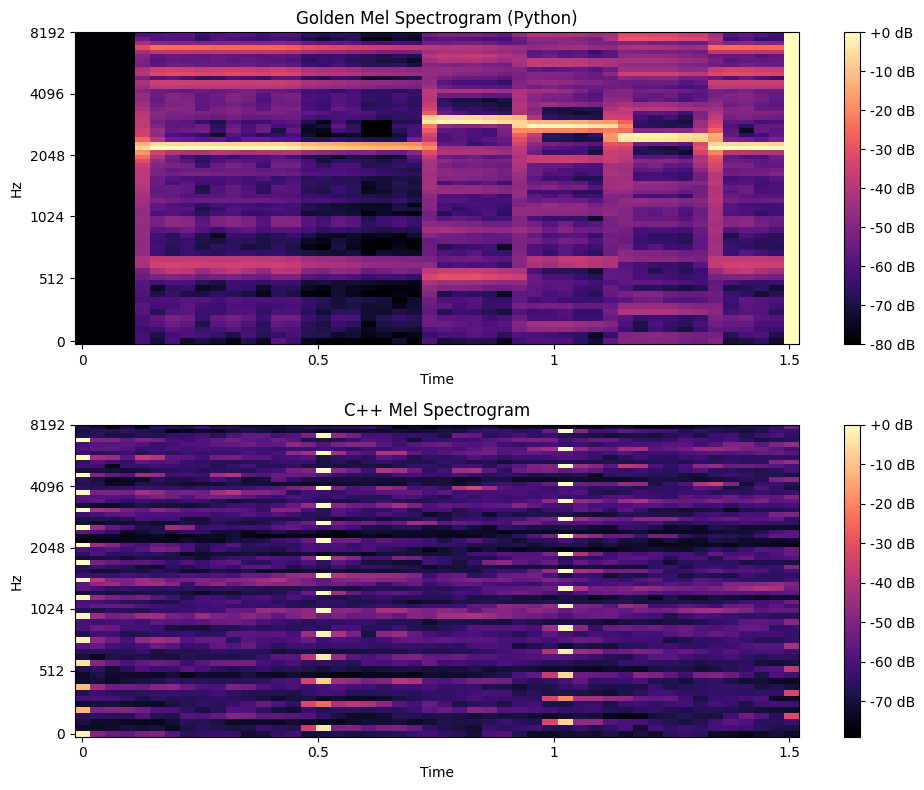

Max difference: 80.0
Mean difference: 15.333915552296242


In [10]:
# --- Compare Spectrograms ---
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Golden Spectrogram
img1 = librosa.display.specshow(golden_spectrogram, sr=CONFIG['sample_rate'], x_axis='time', y_axis='mel', ax=axs[0])
fig.colorbar(img1, ax=axs[0], format='%+2.0f dB')
axs[0].set_title('Golden Mel Spectrogram (Python)')

# C++ Spectrogram
img2 = librosa.display.specshow(cpp_spectrogram, sr=CONFIG['sample_rate'], x_axis='time', y_axis='mel', ax=axs[1])
fig.colorbar(img2, ax=axs[1], format='%+2.0f dB')
axs[1].set_title('C++ Mel Spectrogram')

plt.tight_layout()
plt.show()

# --- Difference ---
difference = np.abs(golden_spectrogram - cpp_spectrogram)
print("Max difference:", np.max(difference))
print("Mean difference:", np.mean(difference))